In [3]:
import torch
from manify.curvature_estimation.delta_hyperbolicity import delta_hyperbolicity
import networkx as nx 
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import shortest_path
import numpy as np
import pydot

In [4]:
# 1) One-hot data/identity matrix

n = 100
X = torch.eye(n)
# Calculate Euclidean distance matrix
dismat = torch.cdist(X, X)

delta_hyperbolicity(dismat)

0.0

In [5]:
# 2) Leaf node deltas

In [6]:
n_nodes = 1000
max_children = 4

In [7]:
# Create tree

G = nx.Graph()

G.add_nodes_from(range(n_nodes))

# Start with node 0 as the root
remaining_nodes = set(range(1, n_nodes))
connected_nodes = {0}

while remaining_nodes:
    # Pick a random connected node to be a parent
    parent = np.random.choice(list(connected_nodes))
    
    # Determine number of children for this parent (1 to max_children)
    n_children = min(np.random.randint(1, max_children+1), len(remaining_nodes))
    
    # Randomly select children from remaining nodes
    children = np.random.choice(list(remaining_nodes), size=n_children, replace=False)
    
    # Add edges between parent and children
    for child in children:
        G.add_edge(parent, child)
        connected_nodes.add(child)
        remaining_nodes.remove(child)

leaf_nodes = [node for node, degree in G.degree() if degree == 1]
root_node = 0

adj_matrix = nx.to_numpy_array(G)

# Calculate shortest paths between all nodes
dist_matrix_full = shortest_path(adj_matrix, directed=False)

leaf_indices = np.array(leaf_nodes)
leaf_dismat = torch.from_numpy(dist_matrix_full[np.ix_(leaf_indices, leaf_indices)])

delta_hyperbolicity(leaf_dismat)

0.0

In [8]:
from manify.manifolds import ProductManifold
from manify.embedders.coordinate_learning import train_coords

In [9]:
CURVATURE = -1
DIMENSION = 7

pm = ProductManifold(device='cuda',signature=[(CURVATURE, DIMENSION)])
leaf_dismat = leaf_dismat.to(device='cuda')
tree_emb, losses = train_coords(pm, leaf_dismat, device='cuda', training_iterations=80)

  0%|          | 0/2080 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
dismat = torch.cdist(tree_emb,tree_emb)
delta_hyperbolicity(dismat)

NameError: name 'tree_emb' is not defined

In [ ]:
# 3) Sampling from the wrapped normal

In [8]:
# Baseline (normal dim and curvature)
CURVATURE = -1
DIMENSION = 5

hyperbolic_manifold = ProductManifold(signature=[(CURVATURE,DIMENSION)], device="cpu")

n_samples = 100
hyperbolic_points, _ = hyperbolic_manifold.sample(
    z_mean=torch.stack([hyperbolic_manifold.mu0] * n_samples),
    sigma_factorized=[torch.stack([torch.eye(DIMENSION)] * n_samples)]
)

hyperbolic_distances = hyperbolic_manifold.pdist(hyperbolic_points)

euclidean_distances = torch.cdist(hyperbolic_points, hyperbolic_points, p=2)

hyperbolic_delta = delta_hyperbolicity(hyperbolic_distances)
euclidean_delta = delta_hyperbolicity(euclidean_distances)

print(f"Hyperbolic delta: {hyperbolic_delta:.6f}")
print(f"Euclidean delta: {euclidean_delta:.6f}")

Hyperbolic delta: 0.167157
Euclidean delta: 0.222012


Hyperbolic delta for K=-3.0: 0.105451
Euclidean delta for K=-3.0: 0.351142
Hyperbolic delta for K=-2.7272727272727275: 0.115615
Euclidean delta for K=-2.7272727272727275: 0.352744
Hyperbolic delta for K=-2.4545454545454546: 0.134079
Euclidean delta for K=-2.4545454545454546: 0.335061
Hyperbolic delta for K=-2.1818181818181817: 0.134475
Euclidean delta for K=-2.1818181818181817: 0.334539
Hyperbolic delta for K=-1.9090909090909092: 0.118443
Euclidean delta for K=-1.9090909090909092: 0.195594
Hyperbolic delta for K=-1.6363636363636365: 0.127524
Euclidean delta for K=-1.6363636363636365: 0.252687
Hyperbolic delta for K=-1.3636363636363638: 0.155028
Euclidean delta for K=-1.3636363636363638: 0.184519
Hyperbolic delta for K=-1.090909090909091: 0.175934
Euclidean delta for K=-1.090909090909091: 0.261222
Hyperbolic delta for K=-0.8181818181818183: 0.193990
Euclidean delta for K=-0.8181818181818183: 0.290706
Hyperbolic delta for K=-0.5454545454545459: 0.232340
Euclidean delta for K=-0.545454545

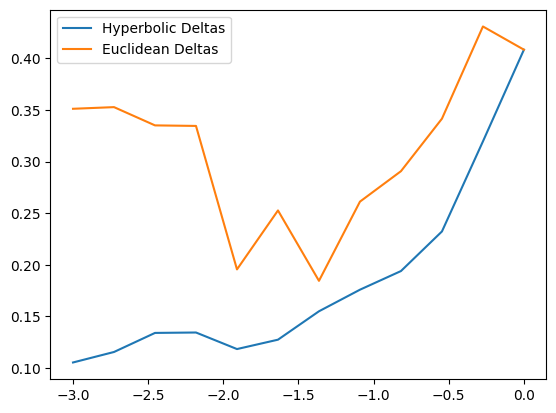

In [9]:
# What if we modify the curvature?

Ks = np.linspace(-3,0,12)
n_samples = 100

h_deltas = []
e_deltas = []

for K in Ks:
    hyperbolic_manifold = ProductManifold(signature=[(K,DIMENSION)], device="cpu")

    hyperbolic_points, _ = hyperbolic_manifold.sample(
        z_mean=torch.stack([hyperbolic_manifold.mu0] * n_samples),
        sigma_factorized=[torch.stack([torch.eye(DIMENSION)] * n_samples)]
    )

    hyperbolic_distances = hyperbolic_manifold.pdist(hyperbolic_points)

    euclidean_distances = torch.cdist(hyperbolic_points, hyperbolic_points, p=2)

    hyperbolic_delta = delta_hyperbolicity(hyperbolic_distances)
    euclidean_delta = delta_hyperbolicity(euclidean_distances)

    h_deltas.append(hyperbolic_delta)
    e_deltas.append(euclidean_delta)

    print(f"Hyperbolic delta for K={K}: {hyperbolic_delta:.6f}")
    print(f"Euclidean delta for K={K}: {euclidean_delta:.6f}")

plt.plot(Ks,h_deltas, label="Hyperbolic Deltas")
plt.plot(Ks,e_deltas, label='Euclidean Deltas')
plt.title('Changing curvature of standard delta')
plt.legend()
plt.show()

In [10]:
from manify.curvature_estimation.delta_hyperbolicity import delta_full

Hyperbolic delta for K=-3.0: 0.231303
Euclidean delta for K=-3.0: 7.514176
Hyperbolic delta for K=-2.7272727272727275: 0.237208
Euclidean delta for K=-2.7272727272727275: 5.432413
Hyperbolic delta for K=-2.4545454545454546: 0.246516
Euclidean delta for K=-2.4545454545454546: 4.190749
Hyperbolic delta for K=-2.1818181818181817: 0.251814
Euclidean delta for K=-2.1818181818181817: 3.416533
Hyperbolic delta for K=-1.9090909090909092: 0.278364
Euclidean delta for K=-1.9090909090909092: 4.624658
Hyperbolic delta for K=-1.6363636363636365: 0.290644
Euclidean delta for K=-1.6363636363636365: 2.577206
Hyperbolic delta for K=-1.3636363636363638: 0.290075
Euclidean delta for K=-1.3636363636363638: 1.372978
Hyperbolic delta for K=-1.090909090909091: 0.331952
Euclidean delta for K=-1.090909090909091: 1.255852
Hyperbolic delta for K=-0.8181818181818183: 0.361103
Euclidean delta for K=-0.8181818181818183: 0.982651
Hyperbolic delta for K=-0.5454545454545459: 0.300200
Euclidean delta for K=-0.545454545

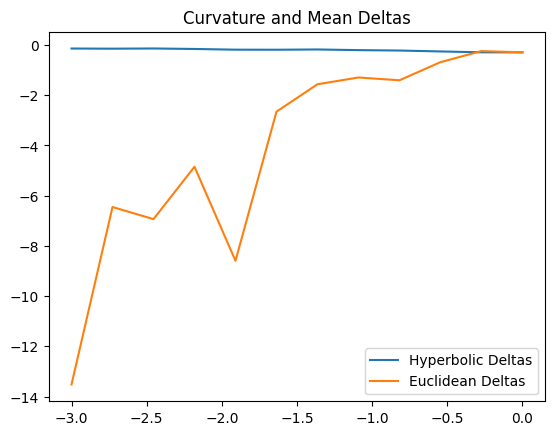

In [35]:
# What if we look at the mean delta hyperbolicities on the wrapped normal while modifying curvature?

Ks = np.linspace(-3,0,12)
n_samples = 100

h_deltas = []
e_deltas = []

for K in Ks:
    hyperbolic_manifold = ProductManifold(signature=[(K,DIMENSION)], device="cpu")

    hyperbolic_points, _ = hyperbolic_manifold.sample(
        z_mean=torch.stack([hyperbolic_manifold.mu0] * n_samples),
        sigma_factorized=[torch.stack([torch.eye(DIMENSION)] * n_samples)]
    )

    hyperbolic_distances = hyperbolic_manifold.pdist(hyperbolic_points)

    euclidean_distances = torch.cdist(hyperbolic_points, hyperbolic_points, p=2)

    hyperbolic_delta = delta_full(hyperbolic_distances).mean().item()
    euclidean_delta = delta_full(euclidean_distances).mean().item()

    h_deltas.append(hyperbolic_delta)
    e_deltas.append(euclidean_delta)

    print(f"Hyperbolic delta for K={K}: {hyperbolic_delta:.6f}")
    print(f"Euclidean delta for K={K}: {euclidean_delta:.6f}")

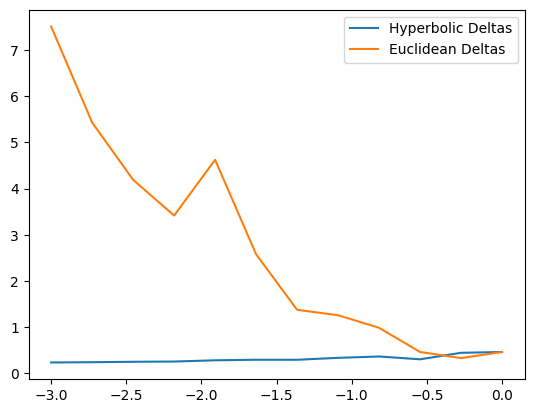

In [12]:
plt.plot(Ks,h_deltas, label="Hyperbolic Deltas")
plt.plot(Ks,e_deltas, label='Euclidean Deltas')
plt.title('Curvature and Mean Deltas')
plt.legend()
plt.show()

In [13]:
from manify.curvature_estimation.delta_hyperbolicity import rel_deltas_full

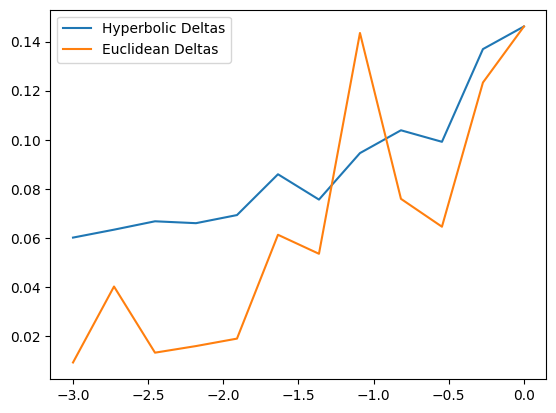

In [14]:
# What if we look at the mean RELATIVE delta hyperbolicities on the wrapped normal while modifying curvature?

Ks = np.linspace(-3,0,12)
n_samples = 100

h_deltas = []
e_deltas = []

for K in Ks:
    hyperbolic_manifold = ProductManifold(signature=[(K,DIMENSION)], device="cpu")

    hyperbolic_points, _ = hyperbolic_manifold.sample(
        z_mean=torch.stack([hyperbolic_manifold.mu0] * n_samples),
        sigma_factorized=[torch.stack([torch.eye(DIMENSION)] * n_samples)]
    )

    hyperbolic_distances = hyperbolic_manifold.pdist(hyperbolic_points)

    euclidean_distances = torch.cdist(hyperbolic_points, hyperbolic_points, p=2)

    hyperbolic_delta = rel_deltas_full(hyperbolic_distances).mean().item()
    euclidean_delta = rel_deltas_full(euclidean_distances).mean().item()

    h_deltas.append(hyperbolic_delta)
    e_deltas.append(euclidean_delta)

plt.plot(Ks,h_deltas, label="Hyperbolic Deltas")
plt.plot(Ks,e_deltas, label='Euclidean Deltas')
plt.title('Curvature and mean RELATIVE deltas')
plt.legend()
plt.show()

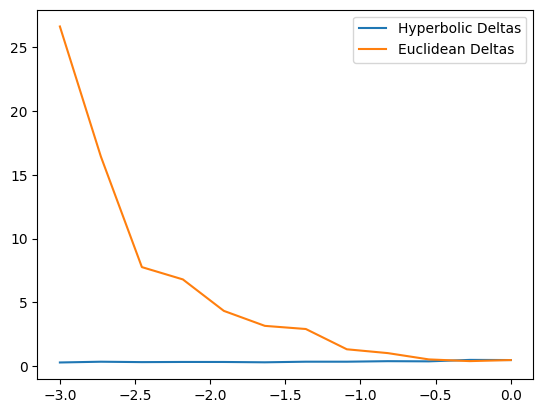

In [19]:
# Delta hyperbolicity and dimensionality?

from manify.curvature_estimation.delta_hyperbolicity import delta_full

dims = np.linspace(2,500,30,dtype=int).tolist()
K = -1
n_samples = 100

h_deltas = []
e_deltas = []

for D in dims:
    hyperbolic_manifold = ProductManifold(signature=[(K,D)], device="cuda")

    hyperbolic_points, _ = hyperbolic_manifold.sample(
        z_mean=torch.stack([hyperbolic_manifold.mu0] * n_samples),
        sigma_factorized=[torch.stack([torch.eye(D)] * n_samples)]
    )

    hyperbolic_distances = hyperbolic_manifold.pdist(hyperbolic_points)

    euclidean_distances = torch.cdist(hyperbolic_points, hyperbolic_points, p=2)

    hyperbolic_delta = delta_hyperbolicity(hyperbolic_distances)
    euclidean_delta = delta_hyperbolicity(euclidean_distances)

    h_deltas.append(hyperbolic_delta)
    e_deltas.append(euclidean_delta)

plt.plot(dims,h_deltas, label="Hyperbolic Deltas")
plt.plot(dims,e_deltas, label='Euclidean Deltas')
plt.title('Delta hyperbolicity and dimension')
plt.legend()
plt.show()